# Dry Beans Classification

by [Sergey Bugaev](https://github.com/bugaevc)

## 0. Abstract

I'll be analyzing the [Dry Beans dataset](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset) using a Bayesian softmax regression model.

## 1. Loading the dataset

In [1]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip
! unzip DryBeanDataset.zip

--2021-04-19 13:57:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4738776 (4.5M) [application/x-httpd-php]
Saving to: ‘DryBeanDataset.zip’

DryBeanDataset.zip  100%[===================>]   4.52M   234KB/s    in 30s     

2021-04-19 13:58:28 (156 KB/s) - ‘DryBeanDataset.zip’ saved [4738776/4738776]

Archive:  DryBeanDataset.zip
   creating: DryBeanDataset/
  inflating: DryBeanDataset/Dry_Bean_Dataset.arff  
  inflating: DryBeanDataset/Dry_Bean_Dataset.txt  
  inflating: DryBeanDataset/Dry_Bean_Dataset.xlsx  


The dataset is originally in [Attribute-Relation File Format](https://waikato.github.io/weka-wiki/formats_and_processing/arff_stable/) (ARFF). I'm going to use [`arff2pandas`](https://github.com/garicchi/arff2pandas) to load it as a Pandas `DataFrame`:

In [2]:
import arff2pandas.a2p

with open('DryBeanDataset/Dry_Bean_Dataset.arff') as f:
    data = arff2pandas.a2p.load(f)

Taking a look at the loaded data:

In [3]:
data

,Area@INTEGER,Perimeter@REAL,MajorAxisLength@REAL,MinorAxisLength@REAL,AspectRation@REAL,Eccentricity@REAL,ConvexArea@INTEGER,EquivDiameter@REAL,Extent@REAL,Solidity@REAL,roundness@REAL,Compactness@REAL,ShapeFactor1@REAL,ShapeFactor2@REAL,ShapeFactor3@REAL,ShapeFactor4@REAL,"Class@{SEKER,BARBUNYA,BOMBAY,CALI,HOROZ,SIRA,DERMASON}"
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


We can see that the columns are named weirdly. Let's fix that:

In [4]:
import re

def to_snake_case(s):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', s).lower()

data = data.rename(columns={
    column: to_snake_case(column.partition('@')[0])
    for column in data.columns
})

Let's also convert the *class* column to be categorial and add a separate numerical *category* column:

In [5]:
data['class'] = data['class'].astype('category')
data['category'] = data['class'].cat.codes
data.dtypes

area                    int64
perimeter             float64
major_axis_length     float64
minor_axis_length     float64
aspect_ration         float64
eccentricity          float64
convex_area             int64
equiv_diameter        float64
extent                float64
solidity              float64
roundness             float64
compactness           float64
shape_factor1         float64
shape_factor2         float64
shape_factor3         float64
shape_factor4         float64
class                category
category                 int8
dtype: object

And so here's our cleaned up data:

In [6]:
data

,area,perimeter,major_axis_length,minor_axis_length,aspect_ration,eccentricity,convex_area,equiv_diameter,extent,solidity,roundness,compactness,shape_factor1,shape_factor2,shape_factor3,shape_factor4,class,category
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER,5
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER,5
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER,5
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER,5
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON,3
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON,3
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON,3
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON,3


There are 13611 rows and 16 predictor columns.

The number of different classes is:

In [7]:
data['category'].nunique()

7

In [8]:
NUM_PREDICTORS = 16
NUM_CLASSES = 7

## 2. Transforming the data

I'm going to:
* split the data into $X$ (predictors) and $y$ (class)
* normalize (rescale) $X$ (but not $y$) to make the model's job easier
* split the data into train and test sets

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = data.iloc[:,:-2], data['category']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

The train set consists of 10208 observations:

In [10]:
X_train.shape, y_train.shape

((10208, 16), (10208,))

And the remaining 3403 are in the test set:

In [11]:
X_test.shape, y_test.shape

((3403, 16), (3403,))

## 3. Regression

Before we start with the Bayesian model, let's fit a simple Ridge regression classifier real quick:

In [12]:
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier().fit(X_train, y_train)

It actually fits quite well:

In [13]:
ridge.score(X_train, y_train), ridge.score(X_test, y_test)

(0.9040948275862069, 0.9065530414340288)

## 4. Bayesian model

I'll model the class outcome as a categorical distribution whose paramaters ($p_j$) are dependent on the predictor variable values ($\mathbf x_i$), with $\beta$ being the (number of predictors) × (number of classes) matrix of linear coefficients and $\alpha$ being the intercept vector. We get $p$ (outcome probabilities) from $\mu = \alpha + \mathbf x \beta$ by applying softmax.

$$
\begin{align}
\alpha_j &\sim \mathcal{N}(0, \sigma^\alpha_j), & j=1,\ldots, 7, \\
\beta_{kj} &\sim \mathcal{N}(0, \sigma^\beta_{kq}), & k=1,\ldots,16, \\ & & j=1,\ldots, 7, \\[5pt]
\mu &= \alpha + \mathbf x \beta, \\
p(\mathbf x) &= \mathrm{Softmax}(\mu_1, \mu_2, \ldots,\mu_7), \\[10pt]
P(t_i = j | \mathbf x_i) &= p_j (\mathbf x_i) & i=1,\ldots, n, \\ & & j=1,\ldots, 7, \\
t_i | \mathbf x_i &\sim \mathrm{Categorical} \left(p (\mathbf x_i) \right), & i=1,\ldots, n.
\end{align}
$$

![Kruschke Style Diagram](diagram-ni.png)

### Non-identifiability

The model is non-identifiable. However, it appears to converge and work just fine! I've tried several identifable models, and none of them worked nearly as well (see below).

## 5. PyMC3

And now, I'm going to build the Bayesian model described above using [PyMC3](https://docs.pymc.io/).

In [14]:
import pymc3 as pm
import theano.tensor as tt

# Create a new model and enter its context:
with pm.Model() as model:
    # Wrap `X_train` into `pm.Data`; this will lets us substitute it for `X_test` later.
    Xl = pm.Data('Xl', X_train)

    alpha = pm.Normal('α', mu=0, sd=1, shape=NUM_CLASSES)
    beta = pm.Normal('β', mu=0, sd=1, shape=(NUM_PREDICTORS, NUM_CLASSES))

    mu = alpha + pm.math.dot(Xl, beta)
    p = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p, observed=y_train)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


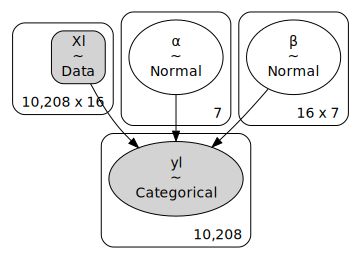

In [15]:
pm.model_to_graphviz(model)

And now, we run the model. This is going to take a long long time.

In [16]:
with model:
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7664 seconds.


## 6. Inspecting the trace

Now that *that* is over, we can render a pretty colorful plot of the trace using [ArviZ](https://arviz-devs.github.io/arviz/):

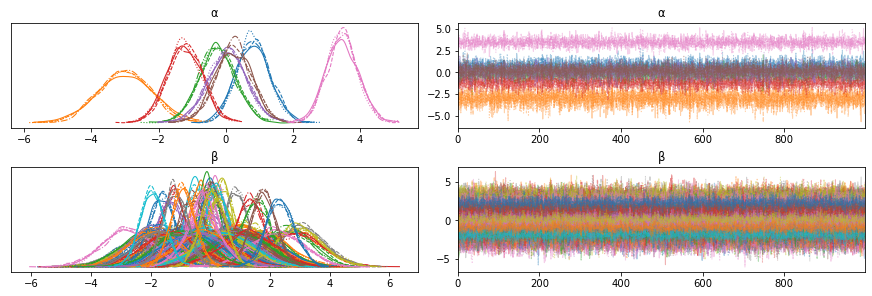

In [17]:
import arviz as az

with model:
    az.plot_trace(trace)

It looks like the chains have all converged nicely, even though it's kind of hard to see due to large number of $\beta$ values.

We can get a different plot with `plot_forest()`:

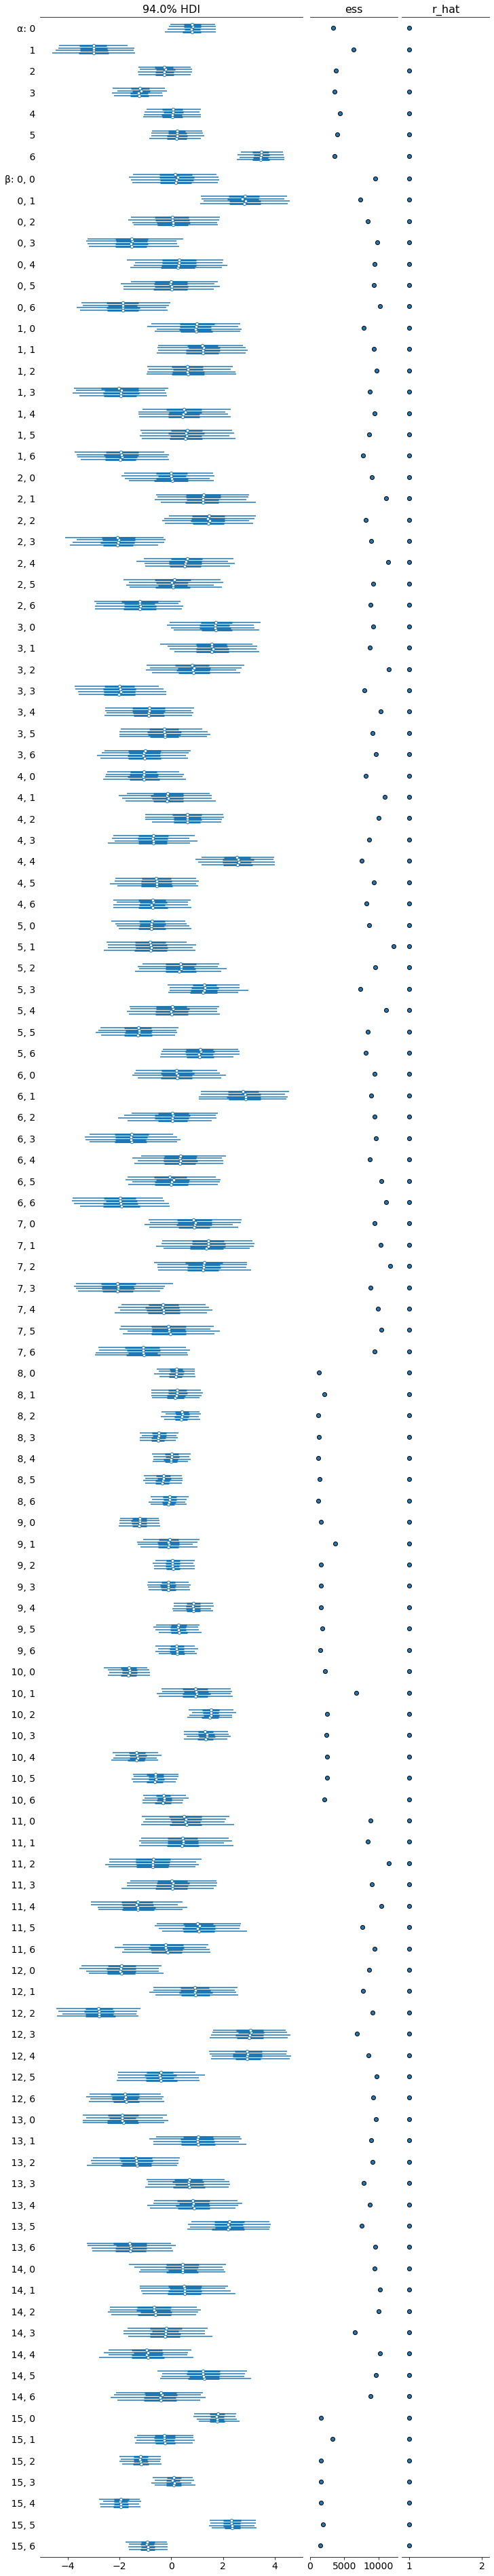

In [18]:
with model:
    az.plot_forest(trace, r_hat=True, ess=True)

Finally, we can ask for stats in table form:

In [19]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],0.816,0.496,-0.138,1.722,0.009,0.006,3382.0,3105.0,3397.0,3194.0,1.0
α[1],-3.007,0.799,-4.393,-1.401,0.010,0.007,6520.0,6339.0,6510.0,2891.0,1.0
α[2],-0.252,0.545,-1.282,0.765,0.009,0.008,3877.0,2563.0,3886.0,3133.0,1.0
α[3],-1.218,0.522,-2.192,-0.216,0.009,0.006,3641.0,3529.0,3654.0,3162.0,1.0
α[4],0.057,0.576,-1.031,1.134,0.009,0.009,4485.0,2133.0,4465.0,2997.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"β[15,2]",-1.182,0.413,-1.974,-0.406,0.010,0.007,1574.0,1574.0,1581.0,2432.0,1.0
"β[15,3]",0.093,0.415,-0.718,0.838,0.010,0.007,1569.0,1569.0,1569.0,2326.0,1.0
"β[15,4]",-1.937,0.410,-2.728,-1.195,0.010,0.007,1565.0,1560.0,1563.0,2260.0,1.0
"β[15,5]",2.354,0.476,1.519,3.286,0.011,0.008,1878.0,1868.0,1876.0,2732.0,1.0


Once again, we sadly can't see the whole table due to the number of $\beta$ values. What we can do is query it for the maximum $\hat R$ explicitly:

In [20]:
pm.summary(trace)['r_hat'].max()

1.01

Looks alright!

## 7. Making predictions & measuring accuracy

We can draw predictions by calling `sample_posterior_predictive()`.

For each step in the trace (so, for each combination of sampled parameter values) and for each data point in the input data, it will yeild a value (the predicted class).

In [21]:
with model:
    samples_train = pm.sample_posterior_predictive(trace)
samples_train['yl'].shape

(4000, 10208)

How do we measure our accuracy against our true *y* labels?

Well, I've got two ideas. The first one is to find the single *most probable* class for each input data point, and simply compare those against the true labels like we would do when computing accuracy for any other machine learning model:

In [22]:
from scipy.stats import mode
import numpy as np

def simple_accuracy(sampled_y, y):
    eq = mode(sampled_y).mode[0] == y
    return np.count_nonzero(eq) / eq.size

In [23]:
simple_accuracy(samples_train['yl'], y_train)

0.9259404388714734

Not bad! In fact, this is better than the Ridge regression I've trained above.

The second idea is that, instead of picking just one most probable result for each data point, we should look at the proportion of correct predictions among the whole set. This way, we'll be assessing how likely the model is to predict the correct answer, rather than whether the single most likely answer is correct or not.

It turns out the implementation of this is even simpler:

In [24]:
def bayesian_accuracy(sampled_y, y):
    eq = sampled_y == y
    return np.count_nonzero(eq) / eq.size

In [25]:
bayesian_accuracy(samples_train['yl'], y_train.to_numpy())

0.8831929124216301

I would expect this to be higher than the simple accuracy ¯\\\_(ツ)\_/¯

Now, I have thought of yet another, third way to measure accuracy. Instead of counting the class predictions sampled from a categorical ditribution with prameters $p$, we could sample $p$ itslef. Then we would know the true probability of our model giving the right answer ($p_{ik}$ for $i$-th data point whose true class is $k$), so we could sum those.

However, implementing that means $p$ has to be a first-class variable as far as PyMC3 is concerned, i.e. `p = pm.Deterministic('p', ...)`. And I've found that doing that slows things down even more. I have actually implemented this for the Iris dataset; but found that the accuracy measured this way is very close to the value of `bayesian_accuracy()` ("the second idea"). So I decided it's not worth doing for the much larger Dry Beans dataset.

Now, let's do the same for the test set. The good news is we don't have to re-sample, so this is going to be quick. We can do this to replace the value of `Xl`:

In [26]:
with model:
    pm.set_data({'Xl': X_test})

And then just measure things the same way as we did for the train set:

In [27]:
with model:
    samples_test = pm.sample_posterior_predictive(trace)
samples_test['yl'].shape

(4000, 3403)

In [28]:
simple_accuracy(samples_test['yl'], y_test)

0.9233029679694388

In [29]:
bayesian_accuracy(samples_test['yl'], y_test.to_numpy())

0.8814513664413752

We get very similar values as for the train set, which means our model is not overfitting (good!)

## 8. Identifiable model(s)

In order to try and make the model identifable, I'm going to explicitly contsrain $\alpha_1 = \beta_{k1} = 0$, or (equivalently) I'm going to remove the first column from $\alpha$ and $\beta$ and prepend a $0$ to $\mu$:

$$
\begin{align}
\alpha_j &\sim \mathcal{N}(0, \sigma^\alpha_j), & j=1,\ldots, 6, \\
\beta_{kj} &\sim \mathcal{N}(0, \sigma^\beta_{kq}), & k=1,\ldots,16, \\ & & j=1,\ldots, 6, \\[5pt]
\mu &= \alpha + \mathbf x \beta, \\
p(\mathbf x) &= \mathrm{Softmax}(0, \mu_1, \mu_2, \ldots,\mu_6), \\[10pt]
P(t_i = j | \mathbf x_i) &= p_j (\mathbf x_i) & i=1,\ldots, n, \\ & & j=1,\ldots, 7, \\
t_i | \mathbf x_i &\sim \mathrm{Categorical} \left(p (\mathbf x_i) \right), & i=1,\ldots, n.
\end{align}
$$

![Kruschke Style Diagram](diagram.png)

And here's the code:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15462 seconds.
The number of effective samples is smaller than 25% for some parameters.


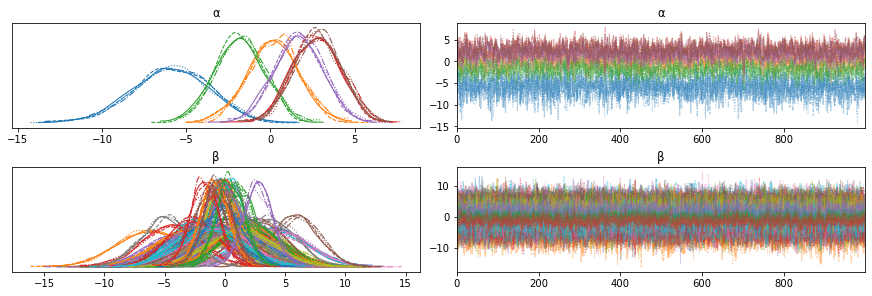

In [30]:
with pm.Model() as model:
    Xl = pm.Data('Xl', X_train)

    alpha = pm.Normal('α', mu=0, sd=3, shape=NUM_CLASSES - 1)
    beta = pm.Normal('β', mu=0, sd=3, shape=(NUM_PREDICTORS, NUM_CLASSES - 1))

    mu = alpha + pm.math.dot(Xl, beta)
    p = tt.concatenate(
        (
            tt.ones((Xl.shape[0], 1)),
            tt.nnet.softmax(mu),
        ),
        axis=1,
    )

    yl = pm.Categorical('yl', p, observed=y_train)

    trace = pm.sample(return_inferencedata=True)
    az.plot_trace(trace)

    samples_train = pm.sample_posterior_predictive(trace)

I have set `sd=3` to give it more room (the original model had `sd=1`); though I have tried different variants of the model, and none worked well.

Here's how it fares:

In [31]:
simple_accuracy(samples_train['yl'], y_train)

0.33532523510971785

In [32]:
bayesian_accuracy(samples_train['yl'], y_train.to_numpy())

0.4538071610501567

Ouch!

I have no idea why it doesn't work well; the same thing does work well on Iris classification.